<a href="https://colab.research.google.com/github/mollah2022/Neural-Network/blob/main/XGBoost_model_with_SMOTE_Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart.csv')

In [3]:
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())

In [4]:
df['BP_Chol_Ratio'] = df['RestingBP'] / df['Cholesterol']
df['HR_Age_Ratio'] = df['MaxHR'] / df['Age']

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

In [6]:
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
                   'BP_Chol_Ratio', 'HR_Age_Ratio']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG',
                       'ExerciseAngina', 'ST_Slope']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [7]:
model = make_imb_pipeline(
    preprocessor,
    SMOTE(random_state=42, sampling_strategy='minority'),
    XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.3,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        scale_pos_weight=1.2,  # Slight weighting for minority class
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

In [8]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak', 'BP_Chol_Ratio',
                                                   'HR_Age_Ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [9]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8768
ROC AUC: 0.9208

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        62
           1       0.90      0.87      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



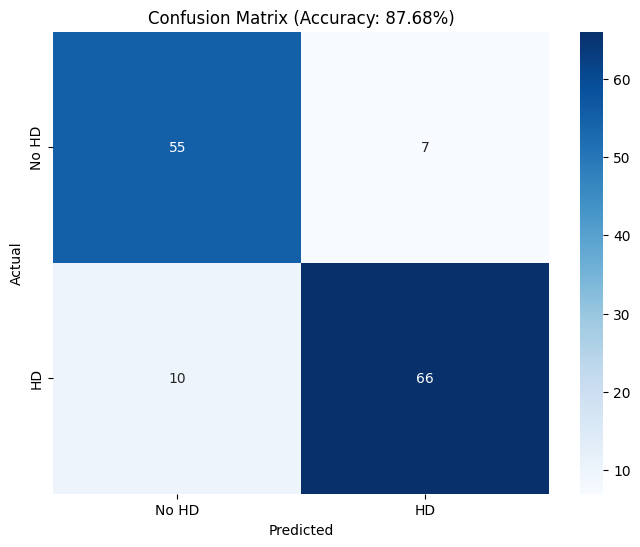

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No HD', 'HD'],
            yticklabels=['No HD', 'HD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy_score(y_test, y_pred)*100))
plt.show()

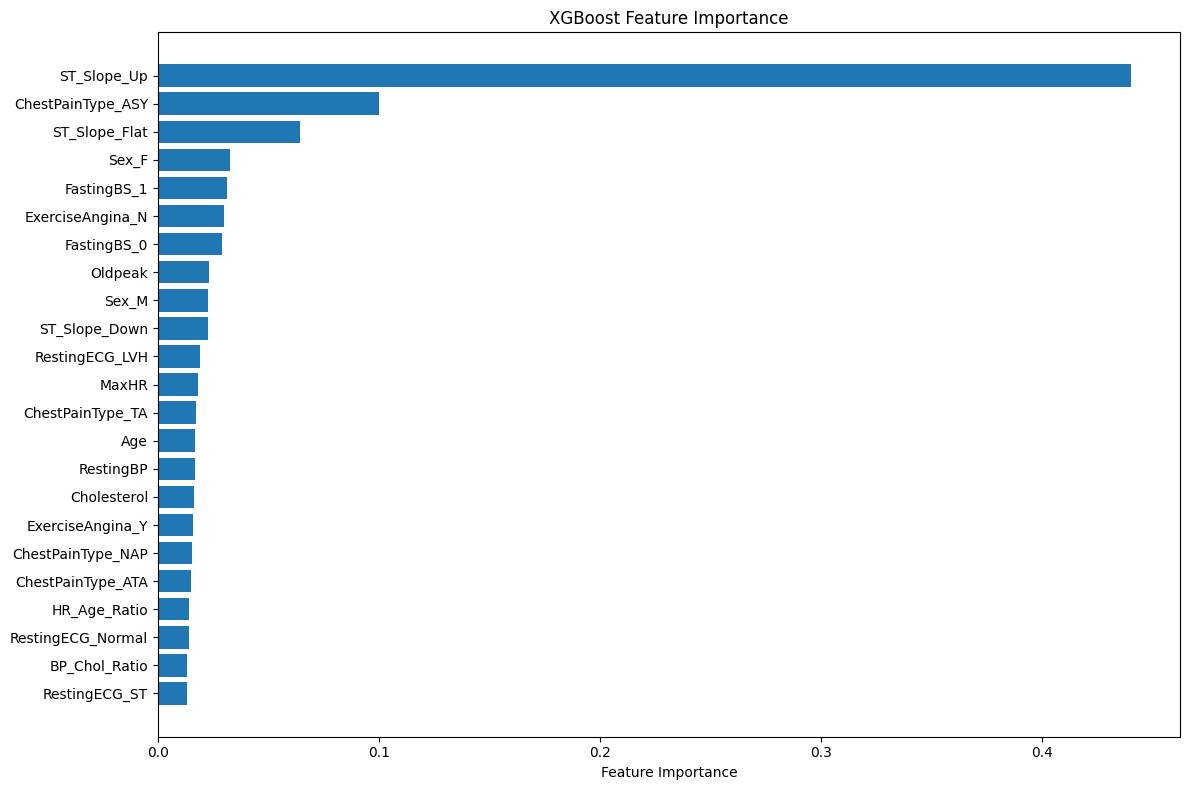

In [11]:
feature_names = numeric_features + list(model.named_steps['columntransformer']
                         .named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features))

importances = model.named_steps['xgbclassifier'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()